In [6]:
import numpy as np

MetaID = 0
MetaDATA = 1
MetaLABEL = 2
MetaSTART = 3
MetaDURATION = 4

print("Loading data...")
metadata = np.loadtxt('/mnt/ExtDrive/sensor data/HT_Sensor_metadata.dat', skiprows=1, dtype=str)
dataset = np.loadtxt('/mnt/ExtDrive/sensor data/HT_Sensor_dataset.dat', skiprows=1)
print("Preprocessing data...")

# data[0] - Linear, no background reduced
# data[1] - Linear, background reduced
# data[2] - Quadratic, no background reduced
# data[3] - Quadratic, background reduced
banana_data = [[], [], [], [], [], []]
wine_data = [[], [], [], [], [], []]
background_data = [[], [], [], [], [], []]

def sqr_features(features, length):
    features_sqr = np.resize(features, length)
    idx = len(features)
    for i in range(0, len(features)):
        for j in range(0, i + 1):
            features_sqr[idx] = features[i] * features[j]
            idx += 1
    return features_sqr

def sqr_features_str(features):
    num_features = len(features)
    for i in range(0, num_features):
        for j in range(0, i + 1):
            features.append(features[i] + "*" + features[j])

feature_names1 = ["time", "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8", "temp", "h"]
feature_names2 = feature_names1.copy()
for i in range(1, len(feature_names2)):
    feature_names2.append(feature_names2[i] + "'")
sqr_features_str(feature_names1)
sqr_features_str(feature_names2)

segment_len = 1 / 60 # one minute increments
next_segment = 0
cur_ind = None
cur_segment_data = []
cur_background_data = None
p_data = None
for entry in dataset:
    if cur_ind is None or int(entry[0]) != int(cur_ind[MetaID]):
        cur_ind = metadata[int(entry[0])]
        cur_background_data = None
        cur_segment_data = []
        next_segment = 0
        
        if cur_ind[MetaLABEL] == 'banana':
            p_data = banana_data
        elif cur_ind[MetaLABEL] == 'wine':
            p_data = wine_data
        else:
            p_data = background_data
        
    cur_segment_data.append(entry[2:])
    if entry[1] < next_segment or entry[1] > float(cur_ind[MetaDURATION]):
        continue
    
    if cur_background_data is None:
        cur_background_data = np.mean(np.array(cur_segment_data), axis=0)
    else:
        p_data[0].append(entry[1:])
        p_data[1].append(np.concatenate((entry[1:], entry[2:] - cur_background_data)))
        p_data[2].append(sqr_features(p_data[0][len(p_data[0])-1], len(feature_names1)))
        p_data[3].append(sqr_features(p_data[1][len(p_data[1])-1], len(feature_names2)))
        
        for i in range(0, 4):
            p_data[i][len(p_data[i]) - 1] = np.concatenate((p_data[i][len(p_data[i]) - 1], [1]))
    
    cur_segment_data = []
    next_segment += segment_len

print("Done")
print(len(feature_names1))
print(len(feature_names2))
print(len(banana_data[0]))
print(len(wine_data[0]))
print(len(background_data[0]))

#   0: id
#   1: time
# 2-9: R1-R8
#  10: temperature
#  11: humidity

Loading data...
Preprocessing data...
Done
77
252
1375
1883
1130


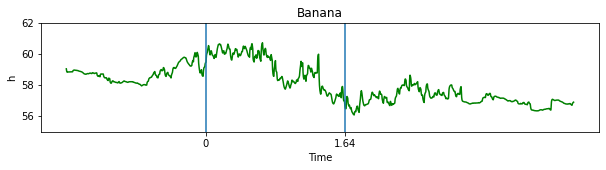

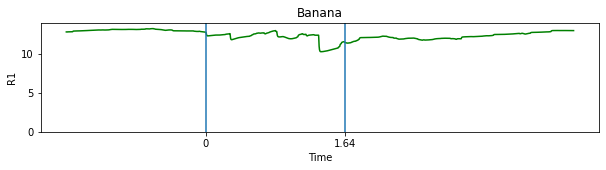

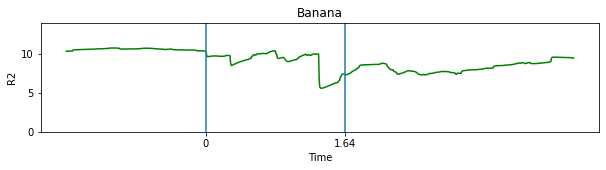

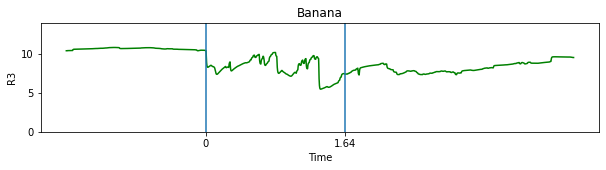

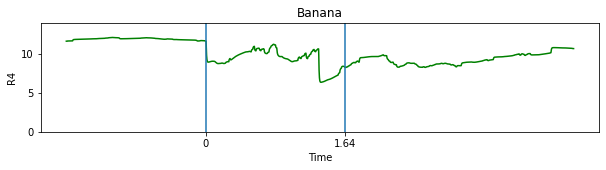

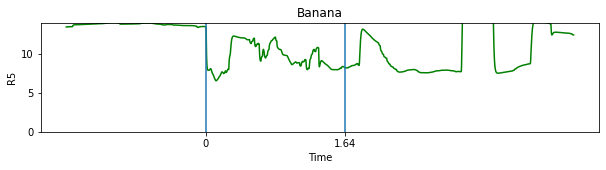

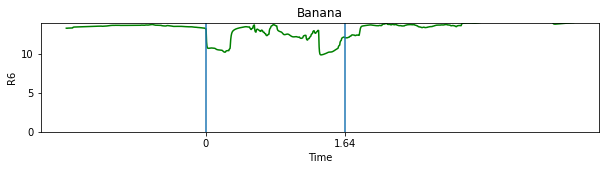

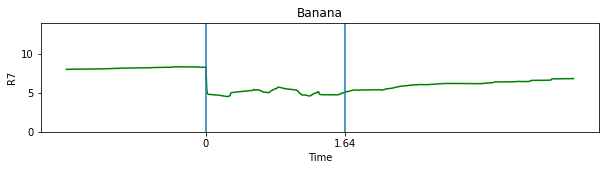

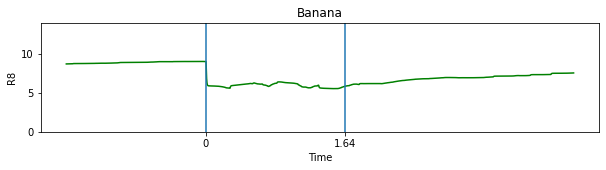

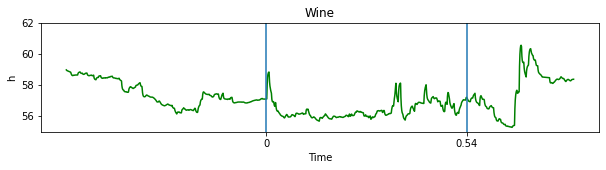

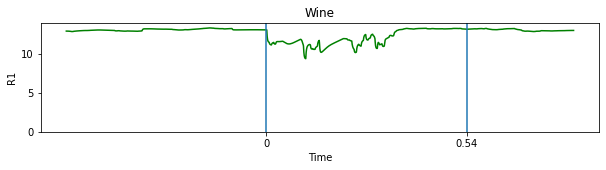

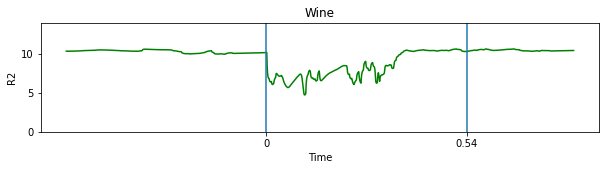

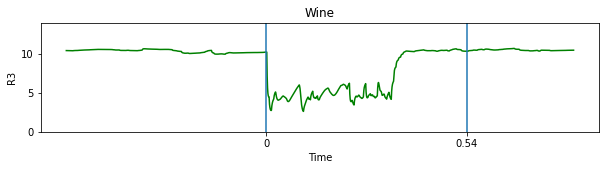

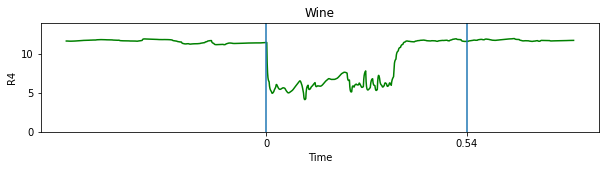

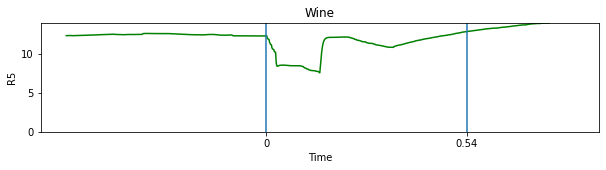

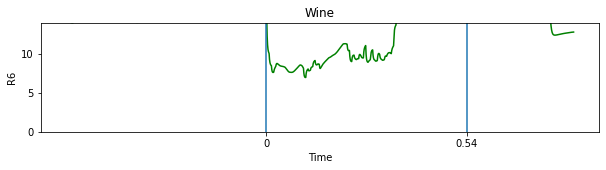

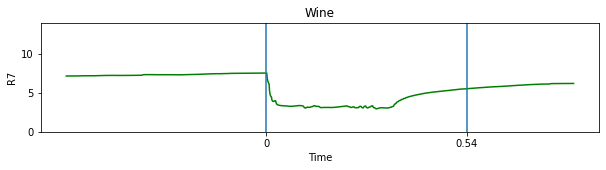

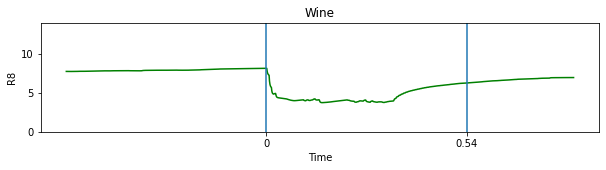

In [83]:
# Plotting
import matplotlib.pyplot as plt

banana_metadata = metadata[0]
plot_banana_data = dataset[dataset[:,0] == 0, 1:]
banana_ind_end = metadata[0,MetaDURATION]

wine_metadata = metadata[1]
plot_wine_data = dataset[dataset[:,0] == 1, 1:]
wine_ind_end = metadata[1,MetaDURATION]

def plot(title, data, ind_end, feature, ylim1, ylim2):
    plt.plot(data[:,0], data[:,feature], 'g-')
    plt.plot([0,0,ind_end,ind_end], [-100, 100, 100, -100], '-')
    plt.ylim(ylim1, ylim2)
    plt.plot()
    plt.xlabel('Time')
    plt.ylabel(feature_names1[feature])
    plt.title(title)
    plt.show()

plot('Banana', plot_banana_data, banana_ind_end, 10, 55, 62)
for i in range(0,8):
    plot('Banana', plot_banana_data, banana_ind_end, i+1, 0, 14)

plot('Wine', plot_wine_data, wine_ind_end, 10, 55, 62)
for i in range(0,8):
    plot('Wine', plot_wine_data, wine_ind_end, i+1, 0, 14)

In [89]:
print(len(banana_data[0]), len(banana_data[0][0]))

display_thresholds = [0.01, 0.3, 0.154, 0.095]
keep_threshold = 1
for i in range(0, 4):
    print("PCA", i)
    
    all_data = np.concatenate((banana_data[i], wine_data[i], background_data[i]))[:,:-1]
    #all_data = np.concatenate((wine_data[i], background_data[i]))[:,:-1]
    all_data_z = all_data - np.mean(all_data, axis=0)
    all_data_z /= np.std(all_data_z, axis=0)
    U, s, VT = np.linalg.svd(all_data_z, full_matrices=False)
    
    p = VT[0,:]
    for j in range(0, len(p)):
        if np.abs(p[j]) > display_thresholds[i]:
            if i == 0 or i == 2:
                print(feature_names1[j], p[j])
            else:
                print(feature_names2[j], p[j])
    
    if i >= 2:
        for j in range(0, len(s)):
            if s[j] < keep_threshold:
                principleComponents = np.transpose(VT[0:j,:])
                print(principleComponents.shape)
                banana_data[i+2] = np.array(banana_data[i])[:,:-1] @ principleComponents
                wine_data[i+2] = np.array(wine_data[i])[:,:-1] @ principleComponents
                background_data[i+2] = np.array(background_data[i])[:,:-1] @ principleComponents
                break

1375 12
PCA 0
time 0.12326535778375529
R1 -0.3644456208944683
R2 -0.3835700418597896
R3 -0.41953950559224296
R4 -0.4027402773213813
R5 -0.033247184888762146
R6 -0.2554714391915216
R7 -0.38460666646556796
R8 -0.37592421217150884
temp -0.09435799672705364
h 0.04615378598769193
PCA 1
PCA 2
R3*R2 -0.1540150809167182
R4*R3 -0.15505178254326285
R7*R2 -0.15435314684199153
R8*R3 -0.15469730488833836
(77, 52)
PCA 3
(252, 142)


In [12]:
def prepare_data(test_data, background_data):
    # Combine positive samples with background samples.
    Xb = np.concatenate((test_data, background_data))
    yb = np.concatenate((np.full(len(test_data), 1), np.full(len(background_data), -1)))

    # Shuffle so that the background samples aren't all in the back.
    np.random.seed(0)
    np.random.shuffle(Xb)
    np.random.seed(0)
    np.random.shuffle(yb)

    num_samples, num_features = Xb.shape
    NUM_PARTS = 8

    # Set up partitions
    setIndices = [[0, int(num_samples / NUM_PARTS)]]
    for i in range(1, NUM_PARTS):
        prev = setIndices[i-1][1]
        setIndices.append([prev, int(prev+num_samples/NUM_PARTS)])
    setIndices[NUM_PARTS-1][1] = num_samples

    holdOuts = [[0, 1]]
    for i in range(1, NUM_PARTS - 1):
        prev = holdOuts[i-1][1]
        holdOuts.append([prev, prev+1])
        
    return Xb, yb, setIndices, holdOuts

In [60]:

def ridge_regression(test_data, background_data):
    Xb, yb, setIndices, holdOuts = prepare_data(test_data, background_data)

    lam_vals = [0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400]
    errorRate = 0
    lambdas = 0
    for j in range(0, len(holdOuts)):
        v1Ind = np.arange(setIndices[holdOuts[j][0]][0], setIndices[holdOuts[j][0]][1])
        v2Ind = np.arange(setIndices[holdOuts[j][1]][0], setIndices[holdOuts[j][1]][1])
        trnInd = list(set(range(len(yb))) - set(v1Ind) - set(v2Ind))

        Xt = Xb[trnInd,:]
        yt = yb[trnInd]
        Xv1 = Xb[v1Ind,:]
        yv1 = yb[v1Ind]
        Xv2 = Xb[v2Ind,:]
        yv2 = yb[v2Ind]

        minErr = float("inf")
        minIdx = 0
        minW = []
        for i in range(0, len(lam_vals)):
            w = np.linalg.inv(Xt.T@Xt + lam_vals[i] * np.identity(num_features))@Xt.T@yt

            error = np.abs(np.sign(Xv1@w) - yv1).sum()
            if error <= minErr:
                minErr = error
                minIdx = i
                minW = w
        #print("Min lam:", lam_vals[minIdx])
        #print("Min err:", minErr)
        lambdas += lam_vals[minIdx]
        errorRate += np.abs(np.sign(Xv2@minW) - yv2.flatten()).sum() / (2 * len(yv2))

    errorRate /= len(holdOuts)
    return errorRate, lambdas / len(lam_vals)

print("Without background-removed features:")
print("  Linear:")
print("    Banana:", ridge_regression(banana_data[0], background_data[0]))
print("    Wine:", ridge_regression(wine_data[0], background_data[0]))
print("  Quadratic:")
print("    Banana:", ridge_regression(banana_data[2], background_data[2]))
print("    Wine:", ridge_regression(wine_data[2], background_data[2]))
print("  Quadratic+PCA:")
print("    Banana:", ridge_regression(banana_data[4], background_data[4]))
print("    Wine:", ridge_regression(wine_data[4], background_data[4]))
print("With background-removed features:")
print("  Linear:")
print("    Banana:", ridge_regression(banana_data[1], background_data[1]))
print("    Wine:", ridge_regression(wine_data[1], background_data[1]))
print("  Quadratic:")
print("    Banana:", ridge_regression(banana_data[3], background_data[3]))
print("    Wine:", ridge_regression(wine_data[3], background_data[3]))
print("  Quadratic+PCA:")
print("    Banana:", ridge_regression(banana_data[5], background_data[5]))
print("    Wine:", ridge_regression(wine_data[5], background_data[5]))

Without background-removed features:
  Linear:
    Banana: (0.12590882794989344, 9.166666666666666)
    Wine: (0.10278901307549322, 71.23333333333333)
  Quadratic:
    Banana: (0.022810455046266283, 216.66666666666666)
    Wine: (0.0436032596989206, 91.7)
  Quadratic+PCA:
    Banana: (0.022811908589568792, 183.33333333333334)
    Wine: (0.04437311027610911, 43.333333333333336)
With background-removed features:
  Linear:
    Banana: (0.05657481242023681, 1.675)
    Wine: (0.0807874414634341, 134.66666666666666)
  Quadratic:
    Banana: (0.0041048062862840745, 2.9166666666666665)
    Wine: (0.008728629665972603, 0.3916666666666666)
  Quadratic+PCA:
    Banana: (0.01551076058106847, 56.18333333333334)
    Wine: (0.026915850944163894, 2.1999999999999997)


In [30]:
from sklearn.svm import LinearSVC

def support_vector_machine(test_data, background_data):
    Xb, yb, setIndices, holdOuts = prepare_data(test_data, background_data)

    errorRate = 0
    for j in range(0, len(holdOuts)):
        vInd = np.arange(setIndices[holdOuts[j][0]][0], setIndices[holdOuts[j][0]][1])
        trnInd = list(set(range(len(yb))) - set(vInd))

        Xt = Xb[trnInd,:]
        yt = yb[trnInd]
        Xv = Xb[vInd,:]
        yv = yb[vInd]
        
        clf = LinearSVC(random_state=0, dual=False, max_iter=10000)
        clf.fit(Xt, np.squeeze(yt))
        w = clf.coef_.transpose()
        errorRate += np.abs(np.sign(Xv@w)[:,0] - yv).sum() / (2 * len(yv))
    
    return errorRate / len(holdOuts)

# SVM time
print("Without background-removed features:")
print("  Linear:")
print("    Banana:", support_vector_machine(banana_data[0], background_data[0]))
print("    Wine:", support_vector_machine(wine_data[0], background_data[0]))
print("  Quadratic+PCA:")
print("    Banana:", support_vector_machine(banana_data[4], background_data[4]))
print("    Wine:", support_vector_machine(wine_data[4], background_data[4]))
print("With background-removed features:")
print("  Linear:")
print("    Banana:", support_vector_machine(banana_data[1], background_data[1]))
print("    Wine:", support_vector_machine(wine_data[1], background_data[1]))
print("  Quadratic+PCA:")
print("    Banana:", support_vector_machine(banana_data[5], background_data[5]))
print("    Wine:", support_vector_machine(wine_data[5], background_data[5]))

Without background-removed features:
  Linear:
    Banana: 0.32131446827932447
    Wine: 0.5661094224924011
  Quadratic+PCA:
    Banana: 0.019169329073482427
    Wine: 0.026595744680851068
With background-removed features:
  Linear:
    Banana: 0.13966225467822913
    Wine: 0.10220364741641337
  Quadratic+PCA:
    Banana: 0.00730260155180283
    Wine: 0.011778115501519757


In [57]:

def logsig(_x):
    return 1/(1+np.exp(-_x))

def neural_network(test_data, background_data):
    Xb, yb, setIndices, holdOuts = prepare_data(test_data, background_data)
    vInd = np.arange(setIndices[holdOuts[0][0]][0], setIndices[holdOuts[0][0]][1])
    trnInd = list(set(range(len(yb))) - set(vInd))

    Xt = Xb[trnInd,:]
    yt = yb[trnInd]
    Xv = Xb[vInd,:]
    yv = yb[vInd]
    
    yt = (yt + 1) / 2
    yv = (yv + 1) / 2
    
    num_samples, num_features = Xt.shape
    num_hidden = 11
    alpha = 0.001
    V = np.random.randn(num_hidden + 1, 1)
    W = np.random.randn(num_features, num_hidden)
        
    for epoch in range(1000):
        ind = np.random.permutation(num_samples)
        alpha = 0.1 / (epoch + 1)
        
        if epoch == 10 or epoch % 100 == 0:
            
            H = logsig(np.hstack((np.ones((len(yt),1)), Xt@W)))
            Yhat = logsig(H@V)[:,0]
            errorRate1 = np.abs(Yhat - yt).sum() / len(yt)
            H = logsig(np.hstack((np.ones((len(yv),1)), Xv@W)))
            Yhat = logsig(H@V)[:,0]
            errorRate2 = np.abs(Yhat - yv).sum() / len(yv)
            print(str(epoch) + ", " + str(errorRate1) + ", " + str(errorRate2))
        
        for i in ind:
            H = logsig(np.hstack((np.ones((1,1)), Xt[[i],:]@W)))
            Yhat = logsig(H@V)
            delta = (Yhat-yt[i])*Yhat*(1-Yhat)
            Vnew = V - alpha*H.T@delta
            gamma = delta@V[1:,:].T*H[:,1:]*(1-H[:,1:])
            Wnew = W - alpha*Xt[[i],:].T@gamma
            V = Vnew
            W = Wnew
        
    H = logsig(np.hstack((np.ones((len(yv),1)), Xv@W)))
    Yhat = logsig(H@V)[:,0]
    errorRate = np.abs(Yhat - yv).sum() / len(yv)
    return errorRate
    
# Neural network time
print("Without background-removed features:")
print("  Banana:", neural_network(banana_data[0], background_data[0]))
print("  Wine:", neural_network(wine_data[0], background_data[0]))
print("With background-removed features:")
print("  Banana:", neural_network(banana_data[1], background_data[1]))
print("  Wine:", neural_network(wine_data[1], background_data[1]))

Without background-removed features:
0, 0.5228686937669126, 0.499603859676662
10, 0.4743832570752472, 0.47797158475694757
100, 0.4218933713383237, 0.43396918560373154
200, 0.3760082142755398, 0.382146749350796
300, 0.2549500463233384, 0.25056834291082486
400, 0.23368379390478553, 0.2286476073693621
500, 0.22150228495214314, 0.2174590875864553
600, 0.21397559998857374, 0.2093448609373446
700, 0.20752567214982293, 0.2046818816382469
800, 0.20337947835329662, 0.20148606322344562
900, 0.19948605102856376, 0.19691193039238883
  Banana: 0.1950082331531717
0, 0.5585346902905474, 0.554383563562258
10, 0.455477746494907, 0.46010328507747034
100, 0.4545005010663167, 0.45834137445892753
200, 0.2642335922583444, 0.25877497653248127
300, 0.2212703913676463, 0.2206218080645983
400, 0.20519426506327812, 0.20498611408543446
500, 0.19065159508180646, 0.1893382658525418
600, 0.1836978363819402, 0.1819434491475204
700, 0.17910326795885195, 0.17716499026573843
800, 0.1750935055046794, 0.17287925067899193
